<a href="https://colab.research.google.com/github/mohamedsayed18/Pose_estimation/blob/master/Posenet_implementation.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [0]:
# Modules to use
import numpy as np
import tensorflow as tf
import cv2 
from matplotlib import pyplot as plt

In [54]:
#load my drive
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [0]:
# Load the model
interpreter = tf.lite.Interpreter("/content/drive/My Drive/innopolis/1st year courses/2nd term/CV/GP/posenet.tflite")
interpreter.allocate_tensors()
input_details = interpreter.get_input_details()   # the input shape
output_details = interpreter.get_output_details()   # the output shape
floating_model = input_details[0]['dtype'] == np.float32  # type of output

In [0]:
# Load the image and convert it to the right size and format
img = cv2.imread("/content/drive/My Drive/innopolis/1st year courses/2nd term/CV/GP/data/pose.jpg")
img2 = cv2.resize(img, (257, 257), interpolation=cv2.INTER_LINEAR)    # resize

if floating_model:
        img2 = (np.float32(img2) - 127.5) / 127.5   # convert to float

fin = img2.reshape((1, 257, 257, 3))    # resize
interpreter.set_tensor(input_details[0]['index'], fin)    # feed the image to model
interpreter.invoke()

In [57]:
# The output of the model
output_data = interpreter.get_tensor(output_details[0]['index'])    # the heatmap output
output_offset = interpreter.get_tensor(output_details[1]['index'])  # the offset output
print(output_data.shape)
print(output_offset.shape)

heatmap = output_data[0]
offsets = output_offset[0]
print(heatmap.shape)
print(offsets.shape)

(1, 9, 9, 17)
(1, 9, 9, 34)
(9, 9, 17)
(9, 9, 34)


In [0]:
def sigmoid(a):
  """sigmoid function"""
  return 1/(1 + np.exp(-a))

In [0]:
def get_keypoints(heatmap, offsets):
  """
  Get the keypoint output
  params:
  heatmap: the heatmap of the output
  offsets: the offset vectors of the output
  return:
  keypointPositions: list of the (x, y) position of every keypoint
  """
  # store some variables
  confidences =[]
  offset_vectors=[]
  hm_positions = []

  scores = sigmoid(heatmap)
  for k in range(17):   # no. of keypoints
    x,y = np.unravel_index(np.argmax(scores[:,:,k]), scores[:,:,k].shape)
    hm_positions.append([x,y])
    confidences.append(scores[x,y,k])
    offset_vectors.append([offsets[x,y,k], offsets[x,y,k+17]])
  keypointPositions = np.add(np.array(hm_positions) * 32, offset_vectors)

  return confidences, keypointPositions

In [0]:
con, kp = get_keypoints(heatmap, offsets)

In [0]:
def draw_on(img, con, kp):
  """Draw on image"""
  img2 = cv2.resize(img, (257,257))   # make a copy and resize
  img2 = cv2.cvtColor(img2, cv2.COLOR_BGR2RGB)
  # draw circles:
  for i in range(len(kp)):
    if con[i]>0.5:
      x, y = int(kp[i,1]), int(kp[i,0])
      centre = (x,y)  
      cv2.circle(img2, centre, 3, (255,0,0), -1)
  return img2

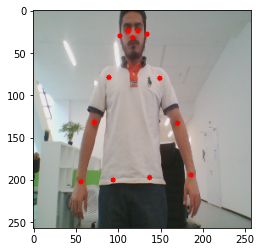

In [63]:
out = draw_on(img, kp)
plt.imshow(out)

In [0]:
# with different photo
# Load the image and convert it to the right size and format
img = cv2.imread("/content/drive/My Drive/innopolis/1st year courses/2nd term/CV/GP/data/balance.jpg")
img2 = cv2.resize(img, (257, 257), interpolation=cv2.INTER_LINEAR)    # resize

if floating_model:
        img2 = (np.float32(img2) - 127.5) / 127.5   # convert to float

fin = img2.reshape((1, 257, 257, 3))    # resize
interpreter.set_tensor(input_details[0]['index'], fin)    # feed the image to model
# The output of the model
output_data = interpreter.get_tensor(output_details[0]['index'])[0]    # the heatmap output
output_offset = interpreter.get_tensor(output_details[1]['index'])[0]  # the offset output
interpreter.invoke()

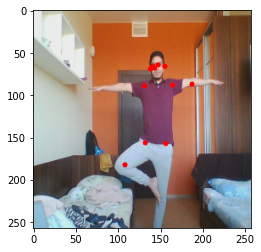

In [75]:
con2, kp2 = get_keypoints(output_data, output_offset)
new_image = draw_on(img, con2, kp2)
new_image.shape
plt.imshow(new_image)